# Covid Data Preparation

In diesem Notebook werden die Daten aufbereitet.

## Imports and Files

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

PATH_COLLECTED_DATA = './computed/collected_data.csv'

## Read data from previously collected data

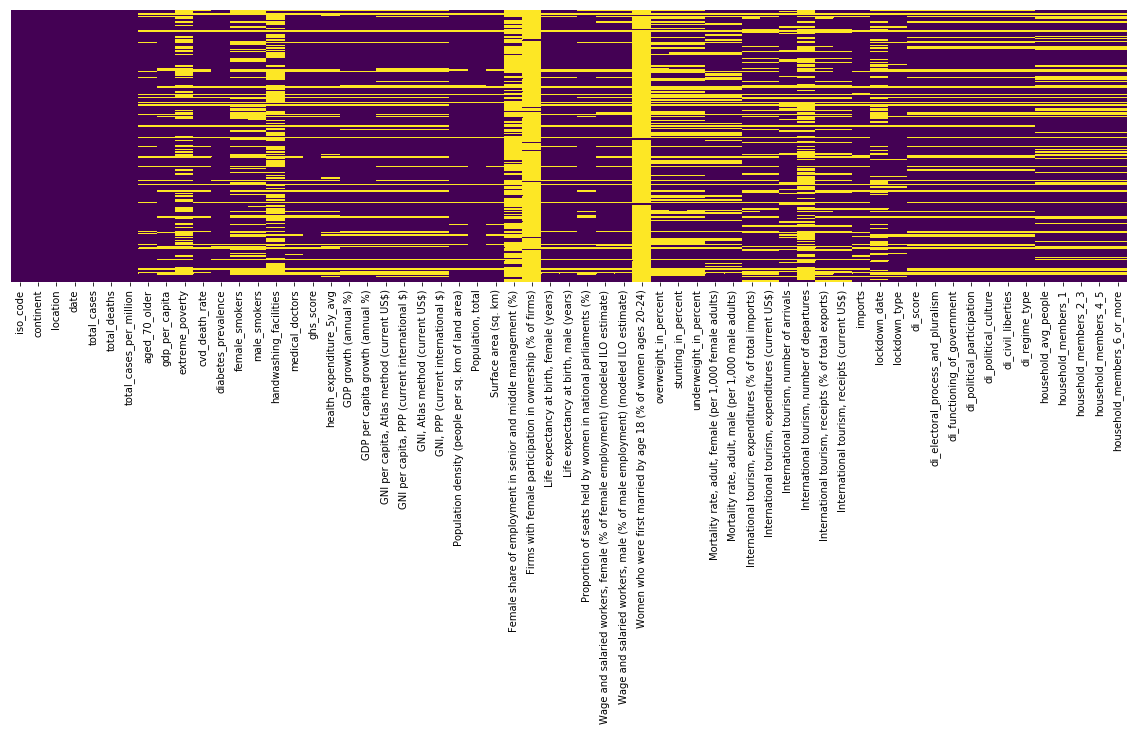

In [2]:
# read data
df = pd.read_csv(PATH_COLLECTED_DATA)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

## Delete features with only a few entries

In [3]:
df.drop(['Female share of employment in senior and middle management (%)','Firms with female participation in ownership (% of firms)', 'Women who were first married by age 18 (% of women ages 20-24)', 'International tourism, number of departures', 'overweight_in_percent', 'stunting_in_percent', 'underweight_in_percent'],inplace=True, axis=1)

## Combine gender specific features into one

In [4]:
# see sex ratio at https://www.cia.gov/library/publications/resources/the-world-factbook/fields/351.html
FEMALE_RATIO = 0.495
MALE_RATIO = 1 - FEMALE_RATIO

df['smokers_percentage'] = FEMALE_RATIO * df['female_smokers'] + MALE_RATIO * df['male_smokers']
df['life_expectancy_at_birth'] = FEMALE_RATIO * df['Life expectancy at birth, female (years)'] + MALE_RATIO * df['Life expectancy at birth, male (years)']
df['wage_and_salaried_workers_percentage_employed'] = FEMALE_RATIO * df['Wage and salaried workers, female (% of female employment) (modeled ILO estimate)'] + MALE_RATIO * df['Wage and salaried workers, male (% of male employment) (modeled ILO estimate)']
df['mortality_rate_per_1000'] = FEMALE_RATIO * df['Mortality rate, adult, female (per 1,000 female adults)'] + MALE_RATIO * df['Mortality rate, adult, male (per 1,000 male adults)']


# mortality rate and life expectancy strongly correlate -> drop mortality_rate_per_1000
# same with wage_and_salaried_workers_percentage_employed -> drop life_expectancy_at_birth because workers have a high probabilty of contact with others

df.drop(['female_smokers', 'male_smokers', 'Life expectancy at birth, female (years)',
         'Life expectancy at birth, male (years)',
         'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)',
         'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)',
         'Mortality rate, adult, female (per 1,000 female adults)',
         'Mortality rate, adult, male (per 1,000 male adults)'], inplace=True, axis=1)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [5]:
df.to_csv('./computed/collected_data_combined_genders.csv', sep=',', encoding='utf-8', index=False)

## Investigate correlation of Democracy Index and subscores + household data

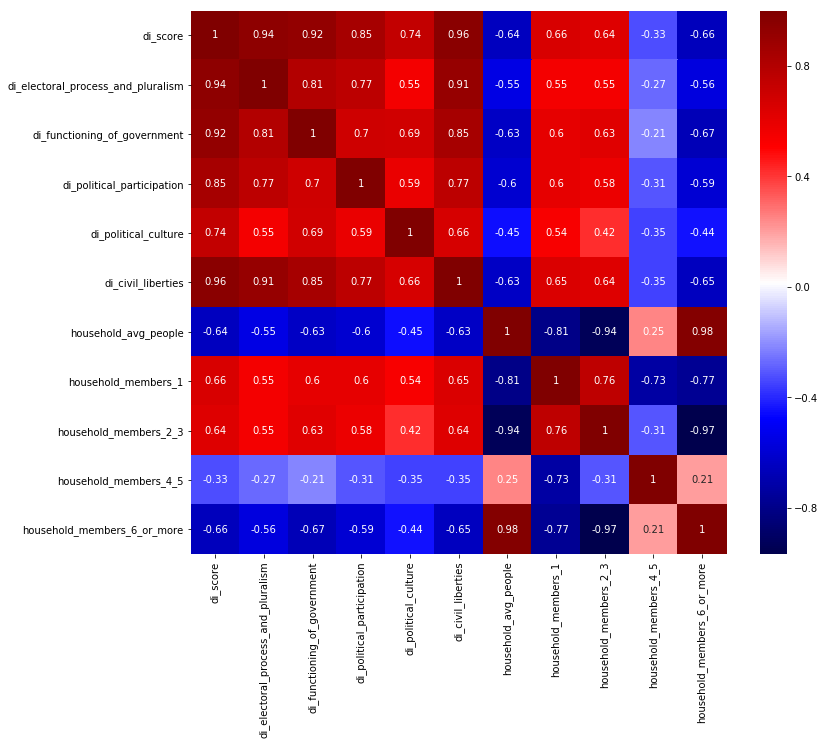

In [6]:
corr = df.loc[:, ['di_score', 'di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation', 'di_political_culture', 'di_civil_liberties', 'household_avg_people', 'household_members_1', 'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more']].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="seismic")
plt.show()

Obviously the Democracy Index and it's subscores are strongly linked together.
Even the subscores have a strong correlation with each other.
Because of this we drop the subscores and keep only the aggregated score for now.

We also only keep the average of people per household because the more detailed numbers correlate and the average should be sufficient.

In [7]:
df.drop(['di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation',
         'di_political_culture', 'di_civil_liberties', 'di_regime_type', 'household_members_1',
         'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more'], inplace=True, axis=1)

## Investigate correlation among all features

In [8]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,handwashing_facilities,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP growth (annual %),GDP per capita growth (annual %),"GNI per capita, Atlas method (current US$)","GNI per capita, PPP (current international $)","GNI, Atlas method (current US$)","GNI, PPP (current international $)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)","International tourism, number of arrivals","International tourism, receipts (% of total exports)","International tourism, receipts (current US$)",imports,di_score,household_avg_people,smokers_percentage,life_expectancy_at_birth,wage_and_salaried_workers_percentage_employed,mortality_rate_per_1000
total_cases,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.13,0.08,0.34,0.3,-0.021,0.017,0.22,0.2,0.77,0.69,-0.027,0.31,0.59,-0.02,-0.017,0.53,0.49,-0.14,0.79,0.67,0.13,-0.15,0.013,0.13,0.15,-0.12
total_deaths,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.17,0.11,0.41,0.38,-0.053,-0.0022,0.28,0.24,0.77,0.66,-0.037,0.25,0.45,0.072,-0.042,0.56,0.63,-0.13,0.84,0.72,0.2,-0.2,0.014,0.18,0.17,-0.1
total_cases_per_million,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.36,0.29,0.19,0.093,-0.066,-0.068,0.45,0.56,0.11,0.085,0.2,-0.046,0.047,0.013,0.21,0.12,0.11,-0.14,0.19,0.13,0.078,-0.31,0.023,0.35,0.37,-0.33
aged_70_older,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.64,0.76,0.7,0.54,-0.14,0.19,0.61,0.6,0.22,0.18,0.031,-0.019,0.062,0.27,-0.067,0.24,0.42,-0.11,0.33,0.33,0.68,-0.79,0.49,0.71,0.63,-0.57
gdp_per_capita,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.65,0.57,0.53,0.21,-0.21,-0.082,0.89,0.98,0.2,0.16,0.29,-0.058,0.061,0.091,0.16,0.24,0.26,-0.15,0.31,0.32,0.45,-0.62,0.13,0.68,0.7,-0.56
extreme_poverty,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.76,-0.6,-0.51,-0.099,0.18,-0.13,-0.4,-0.54,-0.13,-0.14,-0.027,-0.042,-0.12,-0.039,-0.016,-0.16,-0.27,-0.018,-0.18,-0.19,-0.44,0.46,-0.37,-0.76,-0.71,0.72
cvd_death_rate,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.043,-0.2,-0.42,-0.27,0.13,0.11,-0.53,-0.48,-0.16,-0.12,-0.18,0.0093,0.0032,-0.26,0.0024,-0.18,-0.26,-0.0023,-0.27,-0.24,-0.51,0.38,0.21,-0.47,-0.32,0.29
diabetes_prevalence,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,0.57,0.072,-0.045,-0.18,-0.29,-0.2,0.064,0.21,0.051,0.072,0.14,0.022,-0.044,-0.2,0.2,0.023,-0.051,0.3,0.018,0.031,-0.086,-0.042,0.094,0.32,0.37,-0.48
handwashing_facilities,0.13,0.17,0.36,0.64,0.65,-0.76,-0.043,0.57,1,0.63,0.45,0.05,-0.085,0.14,0.64,0.74,0.16,0.14,0.093,0.041,-0.0023,0.0032,0.033,0.24,0.29,0.057,0.25,0.26,0.31,-0.29,0.39,0.83,0.73,-0.73
medical_doctors,0.08,0.11,0.29,0.76,0.57,-0.6,-0.2,0.072,0.63,1,0.49,0.39,-0.091,0.18,0.56,0.62,0.11,0.091,0.039,-0.066,0.058,0.27,0.1,0.15,0.2,-0.083,0.18,0.18,0.47,-0.63,0.48,0.71,0.68,-0.61


To effectively train our models we would like to keep all correlation coefficients below an absolute value of 0.5, thus we drop some features that correlate strongly with others.

In [9]:
df.drop(['GNI per capita, Atlas method (current US$)', 'GNI per capita, PPP (current international $)',
         'GNI, PPP (current international $)', 'GDP growth (annual %)', 'handwashing_facilities',
         'International tourism, expenditures (current US$)', 'International tourism, number of arrivals',
         'International tourism, receipts (current US$)', 'mortality_rate_per_1000',
         'life_expectancy_at_birth'], inplace=True, axis=1)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,di_score,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
total_cases,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,0.13,-0.15,0.013,0.15
total_deaths,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,0.2,-0.2,0.014,0.17
total_cases_per_million,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,0.078,-0.31,0.023,0.37
aged_70_older,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.76,0.7,0.54,0.19,0.22,0.031,-0.019,0.062,0.27,-0.067,-0.11,0.33,0.68,-0.79,0.49,0.63
gdp_per_capita,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,0.45,-0.62,0.13,0.7
extreme_poverty,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.6,-0.51,-0.099,-0.13,-0.13,-0.027,-0.042,-0.12,-0.039,-0.016,-0.018,-0.19,-0.44,0.46,-0.37,-0.71
cvd_death_rate,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,-0.51,0.38,0.21,-0.32
diabetes_prevalence,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.086,-0.042,0.094,0.37
medical_doctors,0.08,0.11,0.29,0.76,0.57,-0.6,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,0.47,-0.63,0.48,0.68
ghs_score,0.34,0.41,0.19,0.7,0.53,-0.51,-0.42,-0.045,0.49,1,0.49,0.21,0.37,0.071,0.13,0.25,0.26,-0.025,-0.33,0.51,0.67,-0.62,0.26,0.54


(209, 30)


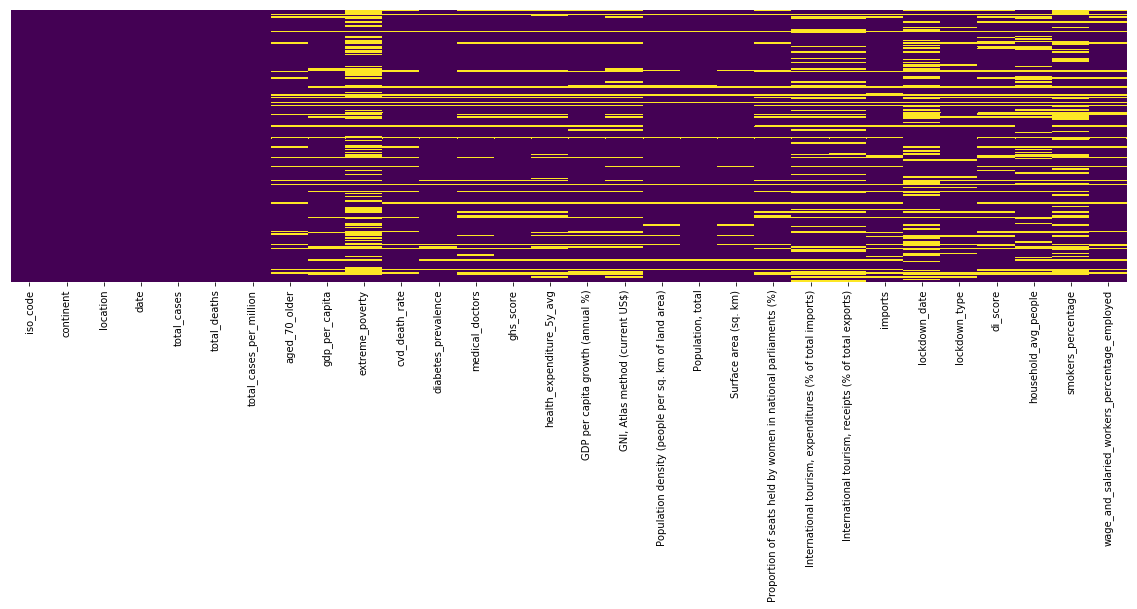

In [10]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

For deciding which feature to delete when two correlate strongly we also take the number of missing values (for that feature) into account.

In [11]:
# remove columns based on correlation + missing values
df.drop(['extreme_poverty', 'aged_70_older', 'di_score'], inplace=True, axis=1)

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases,total_deaths,total_cases_per_million,gdp_per_capita,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
total_cases,1,0.93,0.2,0.16,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,-0.15,0.013,0.15
total_deaths,0.93,1,0.17,0.18,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,-0.2,0.014,0.17
total_cases_per_million,0.2,0.17,1,0.61,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,-0.31,0.023,0.37
gdp_per_capita,0.16,0.18,0.61,1,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,-0.62,0.13,0.7
cvd_death_rate,-0.11,-0.19,-0.27,-0.47,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,0.38,0.21,-0.32
diabetes_prevalence,0.046,0.0011,0.13,0.26,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.042,0.094,0.37
medical_doctors,0.08,0.11,0.29,0.57,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,-0.63,0.48,0.68
ghs_score,0.34,0.41,0.19,0.53,-0.42,-0.045,0.49,1,0.49,0.21,0.37,0.071,0.13,0.25,0.26,-0.025,-0.33,0.51,-0.62,0.26,0.54
health_expenditure_5y_avg,0.3,0.38,0.093,0.21,-0.27,-0.18,0.39,0.49,1,-0.018,0.33,-0.055,-0.075,0.1,0.29,-0.051,-0.15,0.36,-0.43,0.19,0.34
GDP per capita growth (annual %),0.017,-0.0022,-0.068,-0.082,0.11,-0.2,0.18,0.21,-0.018,1,0.063,0.016,0.16,0.022,0.0096,-0.17,0.087,0.082,-0.24,0.16,0.027


Further feature removal depends on what we want to predict, so we save the current data and proceed in other notebooks.

In [12]:
df.to_csv('./computed/collected_data_reduced_features.csv', sep=',', encoding='utf-8', index=False)